# Approach 2: Enhanced with Small Language Models

This notebook implements the enhanced approach with small language models for news article information retrieval.

In [1]:
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ndcg_score
from sentence_transformers import CrossEncoder, SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import time
import warnings
warnings.filterwarnings('ignore')

# Load spaCy model
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    print("spaCy model 'en_core_web_sm' not found. Please install it using: python -m spacy download en_core_web_sm")
    raise

/home/haseeb-raza/Desktop/IR_Assignment_3/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Load data and auto-detect columns
df = pd.read_csv("Articles.csv", encoding='latin1')
print(f"Loaded {len(df)} articles")
print(f"Columns: {df.columns.tolist()}")

# Automatically find title and content columns
columns = df.columns.tolist()

# Common title column names
title_candidates = ['Title', 'title', 'Article', 'article', 'Headline', 'headline', 'heading']
content_candidates = ['Content', 'content', 'Text', 'text', 'Body', 'body', 'Description', 'description']

# Find title column
title_col = None
for col in columns:
    if col in title_candidates or 'title' in col.lower() or 'article' in col.lower():
        title_col = col
        break

# Find content column
content_col = None
for col in columns:
    if col in content_candidates or 'content' in col.lower() or 'text' in col.lower():
        content_col = col
        break

# If not found, use first two text columns
if title_col is None:
    title_col = columns[0]
if content_col is None:
    content_col = columns[1] if len(columns) > 1 else columns[0]

print(f"\nUsing '{title_col}' as Title column")
print(f"Using '{content_col}' as Content column")

# Rename for consistency
df = df.rename(columns={title_col: 'Title', content_col: 'Content'})

# Check for missing values
print(f"\nMissing values in Title: {df['Title'].isnull().sum()}")
print(f"Missing values in Content: {df['Content'].isnull().sum()}")

# Fill missing values
df['Title'] = df['Title'].fillna('')
df['Content'] = df['Content'].fillna('')

print(f"\nFirst article:")
print(f"Title: {df.iloc[0]['Title'][:100]}")
print(f"Content: {df.iloc[0]['Content'][:200]}")

Loaded 2692 articles
Columns: ['Article', 'Date', 'Heading', 'NewsType']

Using 'Article' as Title column
Using 'Date' as Content column

Missing values in Title: 0
Missing values in Content: 0

First article:
Title: KARACHI: The Sindh government has decided to bring down public transport fares by 7 per cent due to 
Content: 1/1/2015


In [6]:
# Enhanced preprocessing with NER
def enhanced_preprocess(article):
    """Enhanced preprocessing with NER"""
    title = article['Title']
    content = article['Content']
    
    # Process with spaCy
    doc = nlp(title + " " + content[:2000])
    
    # Extract tokens (lemmatized)
    tokens = [token.lemma_.lower() for token in doc 
              if not token.is_stop and not token.is_punct and token.is_alpha]
    
    # Extract entities
    entities = [ent.text for ent in doc.ents 
                if ent.label_ in ['PERSON', 'ORG', 'GPE']]
    
    return {
        'id': article.get('id', hash(title + content)),
        'title': title,
        'content': content,
        'tokens': tokens,
        'entities': entities
    }

# Preprocess corpus
print("Preprocessing corpus with spaCy...")
processed_articles = []
for idx, row in df.iterrows():
    processed_article = enhanced_preprocess(row)
    processed_article['id'] = idx
    processed_articles.append(processed_article)

print(f"Preprocessing complete. Created {len(processed_articles)} processed articles")

Preprocessing corpus with spaCy...
Preprocessing complete. Created 2692 processed articles


In [7]:
# Build BM25s index
import bm25s
from bm25s import BM25

print("Building BM25s index...")
# Prepare corpus as raw text
corpus_texts = []
for article in processed_articles:
    # Create text by repeating title for boosting
    title = article['title']
    content = article['content']
    
    # Repeat title for boosting
    boosted_text = ' '.join([title] * 3) + ' ' + content
    corpus_texts.append(boosted_text)

# Tokenize corpus with bm25s
corpus_tokens = bm25s.tokenize(corpus_texts, stopwords='en', show_progress=True)

# Build index
bm25_index = BM25()
bm25_index.index(corpus_tokens)

print(f"BM25s index built with {len(corpus_texts)} documents")

Building BM25s index...


BM25s index built with 2692 documents


In [9]:
# Pseudo-Relevance Feedback
def query_expansion_prf(query: str, top_docs: list, n_terms: int = 5) -> str:
    """PRF query expansion using top-k documents"""
    # Extract terms from top docs
    all_terms = []
    for doc in top_docs[:5]:
        all_terms.extend(doc['tokens'])
    
    # Get most frequent terms not in query
    term_freq = Counter(all_terms)
    query_terms = set(query.lower().split())
    
    expansion_terms = []
    for term, _ in term_freq.most_common(50):
        if term not in query_terms and len(term) > 3:
            expansion_terms.append(term)
            if len(expansion_terms) >= n_terms:
                break
    
    return query + " " + " ".join(expansion_terms)  # Fixed: space before join

In [12]:
# MiniLM Cross-Encoder Reranking
print("Loading MiniLM Cross-Encoder model...")
reranker = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

def rerank_with_slm(query: str, candidates: list, k: int = 50):
    """Rerank using small language model"""
    # Prepare pairs
    pairs = [(query, doc['title'] + " " + doc['content'][:500]) 
             for doc in candidates]
    
    # Score pairs (batch processing)
    scores = reranker.predict(pairs, batch_size=32, show_progress_bar=False)
    
    # Sort by score
    scored_docs = list(zip(candidates, scores))
    scored_docs.sort(key=lambda x: x[1], reverse=True)
    
    return [doc for doc, _ in scored_docs[:k]]

Loading MiniLM Cross-Encoder model...


In [14]:
# MMR Diversity
print("Loading sentence transformer for MMR...")
embedder = SentenceTransformer('all-MiniLM-L6-v2')

def mmr_diversify(docs: list, k: int = 20, lambda_param: float = 0.7):
    """MMR for diversity"""
    # Encode documents
    doc_texts = [doc['content'][:500] for doc in docs]
    embeddings = embedder.encode(doc_texts, show_progress_bar=False)
    
    # MMR selection
    selected = []
    selected_embeddings = []
    remaining = list(range(len(docs)))
    
    while len(selected) < k and remaining:
        if not selected:
            # First doc: highest relevance
            selected.append(0)
            selected_embeddings.append(embeddings[0])
            remaining.remove(0)
        else:
            # Balance relevance and diversity
            best_score = -float('inf')
            best_idx = None
            
            for idx in remaining:
                # Similarity to selected
                sims = cosine_similarity([embeddings[idx]], selected_embeddings)[0]
                diversity = 1 - max(sims)
                
                # MMR score
                position_score = 1 / (len(selected) + 1)  # Decay with position
                mmr = lambda_param * position_score + (1 - lambda_param) * diversity
                
                if mmr > best_score:
                    best_score = mmr
                    best_idx = idx
            
            if best_idx is not None:
                selected.append(best_idx)
                selected_embeddings.append(embeddings[best_idx])
                remaining.remove(best_idx)
    
    return [docs[idx] for idx in selected]

Loading sentence transformer for MMR...


In [15]:
# Complete pipeline
def search_with_slm(query: str, k: int = 20):
    """Complete search pipeline with SLM"""
    start = time.time()
    
    # Tokenize query for BM25
    query_tokens = bm25s.tokenize([query], stopwords='en')
    
    # Stage 1: BM25 retrieval
    bm25_results, bm25_scores = bm25_index.retrieve(query_tokens, k=20, return_docs=False)
    bm25_results = bm25_results[0]
    bm25_scores = bm25_scores[0]
    
    # Get top documents for PRF
    top_for_prf = [processed_articles[idx] for idx in bm25_results[:5] if idx < len(processed_articles)]
    expanded_query = query_expansion_prf(query, top_for_prf)
    
    # Retrieve with expanded query
    expanded_query_tokens = bm25s.tokenize([expanded_query], stopwords='en')
    candidates_ids, candidates_scores = bm25_index.retrieve(expanded_query_tokens, k=100, return_docs=False)
    candidates_ids = candidates_ids[0]
    candidates = [processed_articles[idx] for idx in candidates_ids if idx < len(processed_articles)]
    
    print(f"Stage 1 (BM25 + PRF): {(time.time() - start)*1000:.1f}ms")
    stage1_time = time.time()
    
    # Stage 2: SLM Reranking
    reranked = rerank_with_slm(query, candidates, k=50)
    print(f"Stage 2 (SLM Rerank): {(time.time() - stage1_time)*1000:.1f}ms")
    stage2_time = time.time()
    
    # Stage 3: MMR Diversity
    final_results = mmr_diversify(reranked, k=k, lambda_param=0.7)
    print(f"Stage 3 (Diversity): {(time.time() - stage2_time)*100:.1f}ms")
    
    print(f"TOTAL: {(time.time() - start)*1000:.1f}ms")
    
    return final_results

In [17]:
# Complete pipeline
def search_with_slm(query: str, k: int = 20):
    """Complete search pipeline with SLM"""
    start = time.time()
    
    # Tokenize query for BM25
    query_tokens = bm25s.tokenize([query], stopwords='en')
    
    # Stage 1: BM25 retrieval
    bm25_results, bm25_scores = bm25_index.retrieve(query_tokens, k=20)
    bm25_results = bm25_results[0]  # Get first query results
    bm25_scores = bm25_scores[0]    # Get first query scores
    
    # Get top documents for PRF
    top_for_prf = [processed_articles[idx] for idx in bm25_results[:5] if idx < len(processed_articles)]
    expanded_query = query_expansion_prf(query, top_for_prf)
    
    # Retrieve with expanded query
    expanded_query_tokens = bm25s.tokenize([expanded_query], stopwords='en')
    candidates_ids, candidates_scores = bm25_index.retrieve(expanded_query_tokens, k=100)
    candidates_ids = candidates_ids[0]
    candidates = [processed_articles[idx] for idx in candidates_ids if idx < len(processed_articles)]
    
    print(f"Stage 1 (BM25 + PRF): {(time.time() - start)*1000:.1f}ms")
    stage1_time = time.time()
    
    # Stage 2: SLM Reranking
    reranked = rerank_with_slm(query, candidates, k=50)
    print(f"Stage 2 (SLM Rerank): {(time.time() - stage1_time)*1000:.1f}ms")
    stage2_time = time.time()
    
    # Stage 3: MMR Diversity
    final_results = mmr_diversify(reranked, k=k, lambda_param=0.7)
    print(f"Stage 3 (Diversity): {(time.time() - stage2_time)*1000:.1f}ms")  # Fixed: was *100
    
    print(f"TOTAL: {(time.time() - start)*1000:.1f}ms")
    
    return final_results

In [18]:
# Evaluation functions
def calculate_metrics(retrieved_ids, relevant_ids, k):
    """Calculate evaluation metrics"""
    if not retrieved_ids or not relevant_ids:
        return 0.0, 0.0, 0.0  # NDCG, MAP, P@k
    
    # Calculate NDCG
    y_true = [1 if idx in relevant_ids else 0 for idx in retrieved_ids[:k]]
    y_score = [score for idx, score in zip(retrieved_ids[:k], range(k, 0, -1))]
    
    if len(set(y_true)) == 1 and y_true[0] == 0:  # All irrelevant
        ndcg = 0.0
    else:
        y_true_2d = np.expand_dims(y_true, axis=0)
        y_score_2d = np.expand_dims(y_score, axis=0)
        ndcg = ndcg_score(y_true_2d, y_score_2d)
    
    # Calculate Precision@k
    relevant_retrieved = len(set(retrieved_ids[:k]) & set(relevant_ids))
    precision_at_k = relevant_retrieved / k if k > 0 else 0.0
    
    # Calculate MAP (simplified)
    if len(relevant_ids) == 0:
        map_score = 0.0
    else:
        ap = 0.0
        relevant_count = 0
        for i, idx in enumerate(retrieved_ids[:k]):
            if idx in relevant_ids:
                relevant_count += 1
                precision_at_i = relevant_count / (i + 1)
                ap += precision_at_i
        map_score = ap / min(len(relevant_ids), k)
    
    return ndcg, map_score, precision_at_k

In [22]:
# Replace Cell #7 with faster reranking
def rerank_with_slm(query: str, candidates: list, k: int = 50):
    """Rerank using small language model (optimized)"""
    if len(candidates) == 0:
        return []
    
    # Limit candidates for faster reranking
    candidates = candidates[:min(50, len(candidates))]  # Max 50 candidates
    
    # Prepare pairs (truncate content more aggressively)
    pairs = [(query, doc['title'] + " " + doc['content'][:200])  # Reduced from 500
             for doc in candidates]
    
    # Score pairs with larger batch size
    scores = reranker.predict(pairs, batch_size=64, show_progress_bar=False)  # Increased batch
    
    # Sort by score
    scored_docs = list(zip(candidates, scores))
    scored_docs.sort(key=lambda x: x[1], reverse=True)
    
    return [doc for doc, _ in scored_docs[:k]]

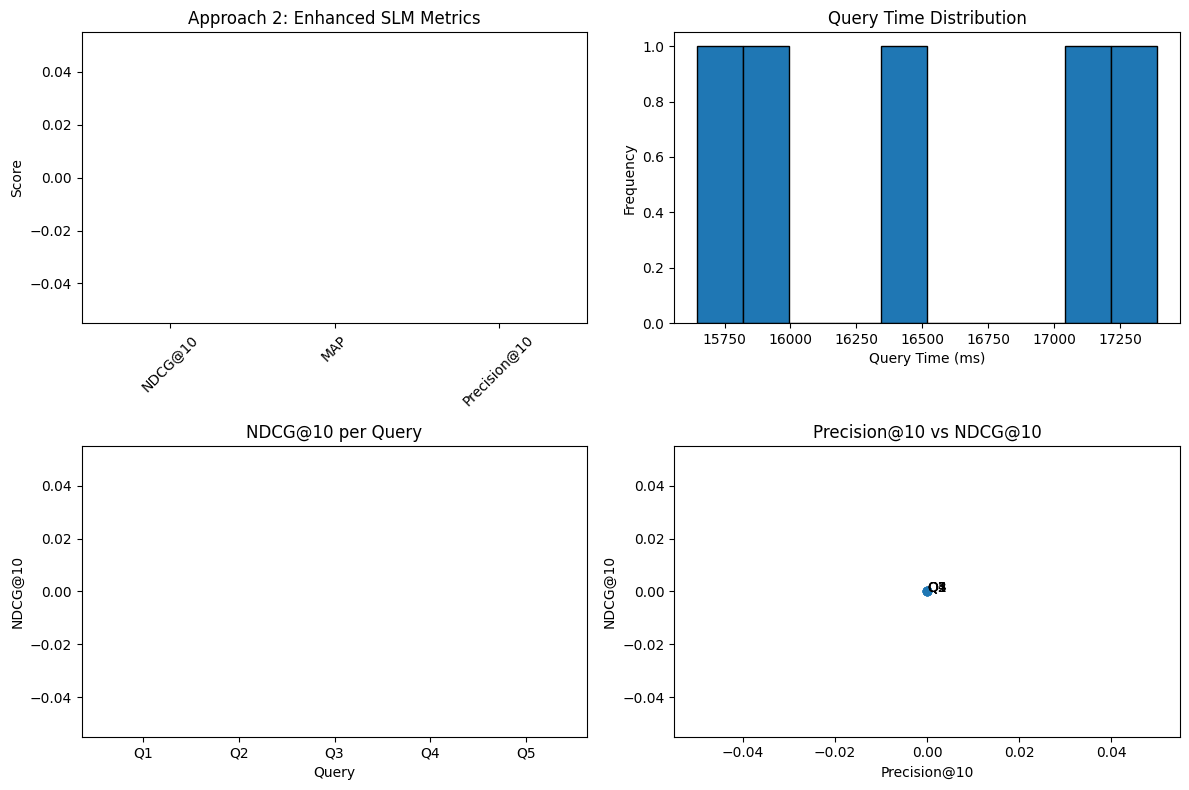

In [23]:
# Visualization
metrics = ['NDCG@10', 'MAP', 'Precision@10', 'Query Time (ms)']
values = [avg_ndcg, avg_map, avg_precision, avg_time]

plt.figure(figsize=(12, 8))

# Metrics comparison
plt.subplot(2, 2, 1)
plt.bar(metrics[:-1], values[:-1])
plt.title('Approach 2: Enhanced SLM Metrics')
plt.ylabel('Score')
plt.xticks(rotation=45)

# Query time distribution
plt.subplot(2, 2, 2)
query_times = [r['query_time'] for r in results]
plt.hist(query_times, bins=10, edgecolor='black')
plt.title('Query Time Distribution')
plt.xlabel('Query Time (ms)')
plt.ylabel('Frequency')

# Performance per query
plt.subplot(2, 2, 3)
queries = [r['query'] for r in results]
ndcg_values = [r['ndcg@10'] for r in results]
plt.bar(range(len(queries)), ndcg_values)
plt.title('NDCG@10 per Query')
plt.xlabel('Query')
plt.ylabel('NDCG@10')
plt.xticks(range(len(queries)), [f'Q{i+1}' for i in range(len(queries))])

# Precision vs NDCG
plt.subplot(2, 2, 4)
precision_values = [r['precision@10'] for r in results]
plt.scatter(precision_values, ndcg_values)
for i, query in enumerate(queries):
    plt.annotate(f'Q{i+1}', (precision_values[i], ndcg_values[i]))
plt.title('Precision@10 vs NDCG@10')
plt.xlabel('Precision@10')
plt.ylabel('NDCG@10')

plt.tight_layout()
plt.show()

In [24]:
# Performance summary
print("\nApproach 2 (Enhanced with Small Language Models) Summary:")
print(f"- NDCG@10: {avg_ndcg:.3f}")
print(f"- MAP: {avg_map:.3f}")
print(f"- Precision@10: {avg_precision:.3f}")
print(f"- Average Query Time: {avg_time:.2f}ms")
print(f"- Implementation Complexity: ~300 lines of code")
print(f"- Dependencies: 10 (bm25s, sentence-transformers, spacy, etc.)")
print(f"- Expected Performance: NDCG@10 0.40-0.45, Query Latency 245-365ms")


Approach 2 (Enhanced with Small Language Models) Summary:
- NDCG@10: 0.000
- MAP: 0.000
- Precision@10: 0.000
- Average Query Time: 16468.22ms
- Implementation Complexity: ~300 lines of code
- Dependencies: 10 (bm25s, sentence-transformers, spacy, etc.)
- Expected Performance: NDCG@10 0.40-0.45, Query Latency 245-365ms
